In [1]:
pip install earthengine-api

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ee

In [5]:
ee.Authenticate()

Enter verification code: 4/1AdQt8qgCWytToeApVIRnFrM2-Oq8v2-Jw3YZ41rY9puLsjlmVug-O7mS9LY

Successfully saved authorization token.


In [6]:
ee.Initialize()

In [7]:
lst = ee.ImageCollection("MODIS/061/MOD11A1")

In [8]:
i_date = '2017-01-01'
f_date = '2020-01-01'
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [9]:
u_lon = 6.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [10]:
scale = 1000 
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

Average daytime LST at urban point: 2.94 °C


In [11]:
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 6.813721430046571, 45.77365530231022, 1483228800000, None, 2],
 ['2017_01_02', 6.813721430046571, 45.77365530231022, 1483315200000, None, 2],
 ['2017_01_03', 6.813721430046571, 45.77365530231022, 1483401600000, None, 2],
 ['2017_01_04', 6.813721430046571, 45.77365530231022, 1483488000000, None, 2]]

In [12]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    df = pd.DataFrame(arr)

    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    df = df[['time','datetime',  *list_of_bands]]

    return df

In [13]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
5,1483660800000,2017-01-06,-9.31
6,1483747200000,2017-01-07,-9.15
8,1483920000000,2017-01-09,-7.89
9,1484006400000,2017-01-10,-13.25
10,1484092800000,2017-01-11,-11.91


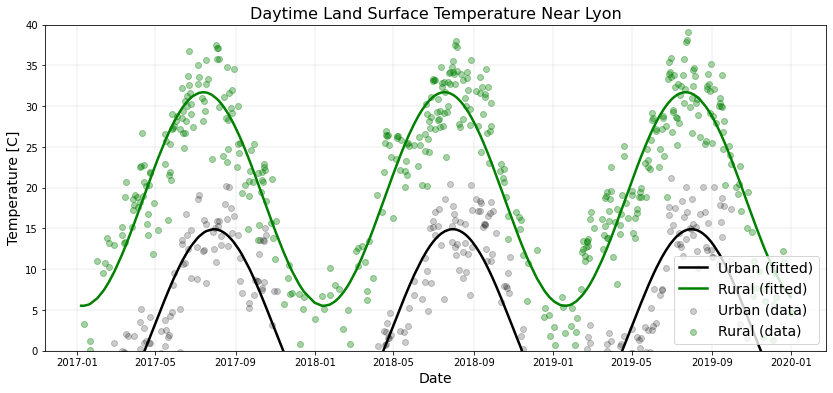

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline


x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  

y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  
## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [15]:
roi = u_poi.buffer(1e6)

In [16]:
lst_img = lst.mean()
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [17]:
from IPython.display import Image
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4731dda19c4af0adbfcf70c9da05aa2a-9f399cd9a0fe1ea7c35b362500fae400:getPixels

Please wait while the thumbnail loads, it may take a moment...
